# TODO: fix later.

## 그래프 설정 및 IR, RGB 데이터 불러오기

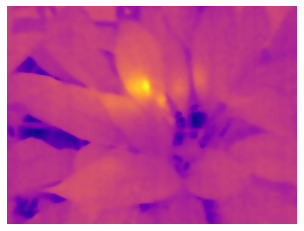

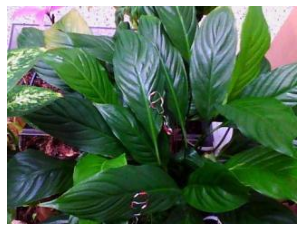

In [1]:
import cv2
import matplotlib.pyplot as plt
import util

plt.rc('font', family='Apple SD Gothic Neo')

WIDTH = 320
HEIGHT = 240

ir = util.load_ir_in_csv('./lily-ir/121.csv')
rgb = cv2.cvtColor(src=cv2.imread('./lily-rgb/FLIR0121- 사진.jpg'),
                   code=cv2.COLOR_BGR2RGB)

util.show_images(ir, rgb)

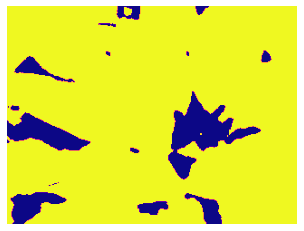

In [2]:
from util import get_leaf_by_jenks

leaf = get_leaf_by_jenks(ir)
util.show_images(leaf)

방법2: 윤곽선(contours) 찾기 및 채우기
* 윤곽선이 잘 찾아지지 않음
* threshold parameter 조정 필요

In [3]:
# import numpy as np

# ir = ir.astype(np.uint8)

# edges = cv2.Canny(ir,
#                   threshold1=0.01,
#                   threshold2=0.02)
# plt.imshow(edges)
# plt.show()

방법3: Jenks Natural Breaks 기법
* 1D에 최적화된 K-Means 클러스터링이라고 알려짐

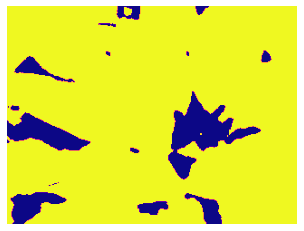

In [4]:
from jenkspy import jenks_breaks
import numpy as np
import util

predict = get_leaf_by_jenks(ir)

util.show_images(predict)


방법4: K-Means 클러스터링(좌표 포함)

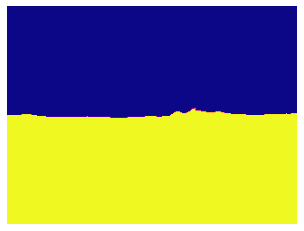

In [5]:
import numpy as np
import util

predict = util.get_leaf_by_kmeans_with_coordination(ir)

util.show_images(predict)


excess-green index 계산
* RGB 이미지를 통해 계산한 값으로, segmentation의 성능 평가를 하기 위함

In [6]:
exg = util.get_excess_green(rgb)
label = util.get_leaf_by_jenks(exg)

util.show_images(exg, label)

AttributeError: module 'util' has no attribute 'get_leaf_with_jenks'

잎 영역의 온도 구하기

In [ ]:
max_temperature = np.max(ir[predict == 0xFF])
min_temperature = np.min(ir[predict == 0xFF])
mean_temperature = cv2.mean(ir, predict)[0]

print('온도 최대값:', max_temperature)
print('온도 최소값:', min_temperature)
print('온도 평균값:', mean_temperature)

온도 최대값: 28
온도 최소값: 25
온도 평균값: 25.163225226471198
